# Image Segmentation by Supervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm, tqdm_notebook
import random
import os

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## 각종 transforms 추가

In [3]:
# float32로 자료형을 변경하여 plt로 변경가능하게

x_train = x_train.astype(dtype="float32")
y_train = y_train.astype(dtype="int32")

x_test = x_test.astype(dtype="float32")
y_test = y_test.astype(dtype="int32")

In [4]:
# rotattion
def rotation(image, label, degree=90):

    func_plt = transforms.functional.to_pil_image
    func_rotate = transforms.functional.rotate
    func_tensor = transforms.functional.to_tensor


    for i in range(len(image)):

        trans_image = func_plt(image[i])
        trans_image = func_rotate(trans_image, degree)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        trans_label = func_plt(label[i])
        trans_label = func_rotate(trans_label, degree)
        trans_label = func_tensor(trans_label)
        trans_label = trans_label.numpy()

        if i == 0:
            image_list = trans_image
            label_list = trans_label
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)
            label_list = np.concatenate([label_list, trans_label], axis=0)

    return image_list, label_list

In [5]:
# y축 대칭
def horizonalflip(image, label):
    transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(p=1),
                                    transforms.ToTensor()
    ])

    for i in range(len(image)):
        trans_image = transform(image[i])
        trans_image = trans_image.numpy()

        trans_label = transform(label[i])
        trans_label = trans_label.numpy()

        if i == 0:
            image_list = trans_image
            label_list = trans_label
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)
            label_list = np.concatenate([label_list, trans_label], axis=0)

    return image_list, label_list

In [6]:
# x_train_90,  y_train_90    = rotation(x_train, y_train, degree=90)
x_train_180, y_train_180   = rotation(x_train, y_train, degree=180)
# x_train_270, y_train_270   = rotation(x_train, y_train, degree=270)
x_train_flip, y_train_flip = horizonalflip(x_train, y_train)

In [7]:
trans_x_train = x_train_flip
trans_y_train = y_train_flip
# trans_x_train = np.concatenate([x_train_flip, x_train_180], axis=0)
# trans_y_train = np.concatenate([y_train_flip, y_train_180], axis=0)

print("shape of transformed x_train : ", trans_x_train.shape)
print("shape of transformed y_train : ", trans_y_train.shape)

x_train = np.concatenate([trans_x_train, x_train], axis=0)
y_train = np.concatenate([trans_y_train, y_train], axis=0)

print("\nafter merge, shape of x_train : ", x_train.shape)
print("after merge, shape of y_train : ", y_train.shape)

shape of transformed x_train :  (600, 128, 128)
shape of transformed y_train :  (600, 128, 128)

after merge, shape of x_train :  (1200, 128, 128)
after merge, shape of y_train :  (1200, 128, 128)


## Image Patch

In [8]:
# train image patch
for m in range(len(x_train)):
    
    image = x_train[m]
    label = y_train[m]

    image = transforms.functional.to_pil_image(image)
    label = transforms.functional.to_pil_image(label)

    # #RandomCrop For Pair 
    # i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(64, 64))
    # image = transforms.functional.crop(image, i, j, h, w) 
    # label = transforms.functional.crop(label, i, j, h, w)

    image = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
    label = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)

    image = transforms.functional.to_tensor(image)
    label = transforms.functional.to_tensor(label)

    image = image.numpy()
    label = label.numpy()

    if m == 0:
        image_list = image
        label_list = label
    else:
        image_list = np.concatenate([image_list, image], axis=0)
        label_list = np.concatenate([label_list, label], axis=0)

x_train = image_list
y_train = label_list
print("shape of x_train : ", x_train.shape)
print("shape of y_train : ", y_train.shape)

shape of x_train :  (1200, 64, 64)
shape of y_train :  (1200, 64, 64)


In [9]:
# test image patch
for i in range(len(x_test)):
    image = transforms.functional.to_pil_image(x_test[i])
    label = transforms.functional.to_pil_image(y_test[i])

    image = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
    label = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)

    image = transforms.functional.to_tensor(image)
    label = transforms.functional.to_tensor(label)

    image = image.numpy()
    label = label.numpy()

    if i == 0:
        image_list = image
        label_list = label
    else:
        image_list = np.concatenate([image_list, image], axis=0)
        label_list = np.concatenate([label_list, label], axis=0)

x_test = image_list
y_test = label_list
print("shape of x_test : ", x_test.shape)
print("shape of y_test : ", y_test.shape)

shape of x_test :  (400, 64, 64)
shape of y_test :  (400, 64, 64)


## hyper-parameters

In [10]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 150
size_minibatch  = 64
learning_rate   = 0.1
weight_decay    = 0

## custom data loader for the PyTorch framework

In [11]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label 
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)
        
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [12]:
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [13]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 64, 64])
shape of the label in the training dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 64, 64])
shape of the label in the testing dataset: torch.Size([1, 64, 64])
*******************************************************************


## class for the neural network 

In [14]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BottleneckResnet(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BottleneckResnet, self).__init__()
        self.conv1 = conv1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64

        # Modules
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self._init_weights()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), 
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
       x = self.conv1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.maxpool(x)
       low_level_feat1 = x

       x = self.layer1(x)
       low_level_feat2 = x
       x = self.layer2(x)
       low_level_feat3 = x
       x = self.layer3(x)
       low_level_feat4 = x
       x = self.layer4(x)
       low_level_feat5 = x
       return [low_level_feat1, low_level_feat2, low_level_feat3, low_level_feat4, low_level_feat5]


    def _init_weights(self):
       for m in self.modules():
           if isinstance(m, nn.Conv2d):
               n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
               m.weight.data.normal_(0, math.sqrt(2. / n))
           elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [15]:
class Bottleneck(nn.Module):
    expansion = 4


    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class FPN(nn.Module):

    def __init__(self, num_blocks, num_classes, backbone):
        super(FPN, self).__init__()
        self.in_planes = 64
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        BatchNorm = nn.BatchNorm2d
        self.back_bone = backbone

        # Bottom-up layers
        self.layer1 = self._make_layer(Bottleneck,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(Bottleneck, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, num_blocks[3], stride=2)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d( 256, 256, kernel_size=1, stride=1, padding=0)

		# Semantic branch
        self.semantic_branch = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, self.num_classes, kernel_size=1, stride=1, padding=0)
        # num_groups, num_channels
        self.gn1 = nn.GroupNorm(128, 128) 
        self.gn2 = nn.GroupNorm(256, 256)

        self.upupup = nn.Upsample(size=(64, 64))

    def _upsample(self, x, h, w):
        return F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)


    def _make_layer(self, Bottleneck, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_planes, planes, stride))
            self.in_planes = planes * Bottleneck.expansion
        return nn.Sequential(*layers)


    def _upsample_add(self, x, y):
        _,_,H,W = y.size()
        return F.interpolate(x, size=(H,W), mode='bilinear', align_corners=True) + y


    def forward(self, x):
        # Bottom-up using backbone
        low_level_features = self.back_bone(x)
        c1 = low_level_features[0]
        c2 = low_level_features[1]
        c3 = low_level_features[2]
        c4 = low_level_features[3]
        c5 = low_level_features[4]

        # Top-down
        p5 = self.toplayer(c5)
        p4 = self._upsample_add(p5, self.latlayer1(c4))
        p3 = self._upsample_add(p4, self.latlayer2(c3))
        p2 = self._upsample_add(p3, self.latlayer3(c2))


        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)


        # Semantic
        _, _, h, w = p2.size()
        # 256->256
        s5 = self._upsample(F.relu(self.gn2(self.conv2(p5))), h, w)
        # 256->256
        s5 = self._upsample(F.relu(self.gn2(self.conv2(s5))), h, w)
        # 256->128
        s5 = self._upsample(F.relu(self.gn1(self.semantic_branch(s5))), h, w)

        # 256->256
        s4 = self._upsample(F.relu(self.gn2(self.conv2(p4))), h, w)
        # 256->128
        s4 = self._upsample(F.relu(self.gn1(self.semantic_branch(s4))), h, w)

        # 256->128
        s3 = self._upsample(F.relu(self.gn1(self.semantic_branch(p3))), h, w)

        s2 = F.relu(self.gn1(self.semantic_branch(p2)))
        p = self._upsample(self.conv3(s2 + s3 + s4 + s5), 4 * h, 4 * w)
        p = self.upupup(x)

        return p

In [16]:
# model = ResNet(BottleneckResnet, [3, 4, 5, 3]).to(device)
# model = FPN([3, 4, 5, 3], 1, model).to(device)

# from torchsummary import summary as summary_
# summary_(model, (1, 64, 64))

## build network

In [17]:
model = ResNet(BottleneckResnet, [3, 4, 5, 3]).to(device)
model = FPN([3, 4, 5, 3], 1, model).to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# from torchsummary import summary as summary_
# summary_(model, (1, 64, 64))

a = torch.rand(1, 1, 64, 64).to(device)
x = model(a)
print(x.shape)

torch.Size([1, 1, 64, 64])


## compute the prediction

In [18]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [19]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    bce = nn.BCEWithLogitsLoss().to(device)

    loss = bce(prediction, label)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [20]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [21]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [22]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        image.requires_grad = True
        label.requires_grad = True

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [23]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [24]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm_notebook(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

    print(f"epoch : {i}")
    print(f"\ttrain loss : {loss_train['mean']}, train acc : {accuracy_train['mean']}")
    print(f"\ttest loss  : {loss_test['mean']},  test acc  : {accuracy_test['mean']}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/150 [00:00<?, ?it/s]

epoch : 0
	train loss : 0.7310611175166236, train acc : 35.17063269726054
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 1
	train loss : 0.7305956217977736, train acc : 35.323477071661394
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 2
	train loss : 0.7311430474122366, train acc : 35.17607769854164
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 3
	train loss : 0.7318894863128662, train acc : 35.224350869391785
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 4
	train loss : 0.731513563129637, train acc : 35.254064940137575
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 5
	train loss : 0.7308897144264646, train acc : 35.222272968655204
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 6
	train loss : 0.7310731841458215, train acc : 35.305976993740295
	test loss  : 0.7211028834184011,  test acc  : 36.37528470901583
epoch : 7
	train loss :

---

# functions for visualizing the results 

---

## plot curve

In [25]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [26]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [27]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [28]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [29]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [30]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [31]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [32]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [33]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [34]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [35]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [36]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [37]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [38]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [39]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [40]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [41]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [42]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [43]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [44]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [45]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [46]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [47]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



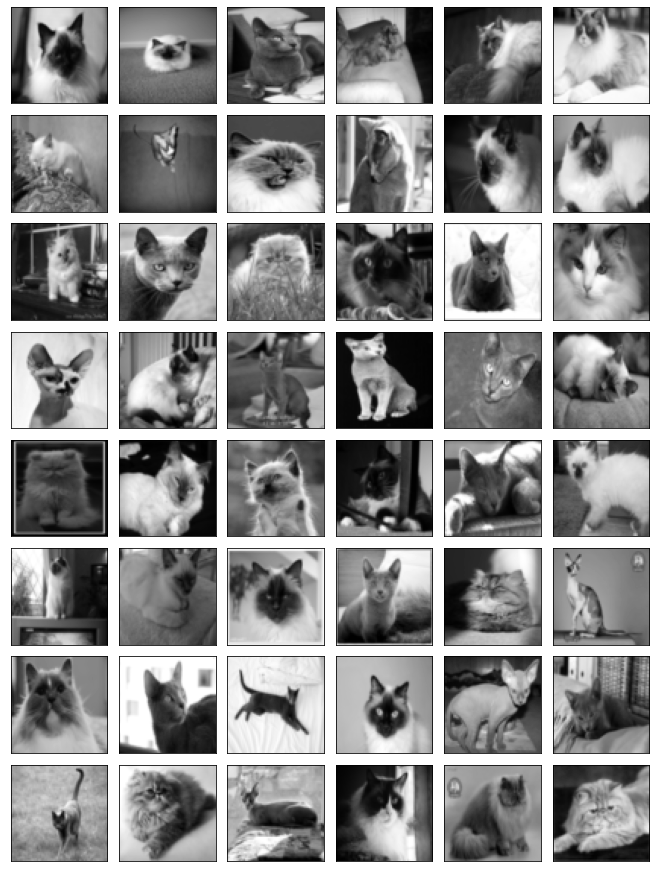


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



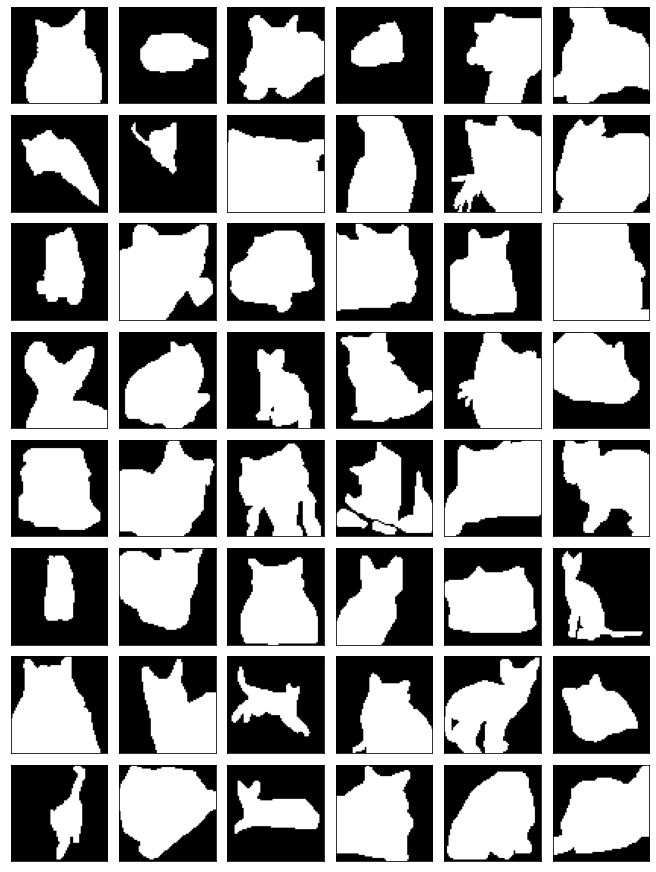


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



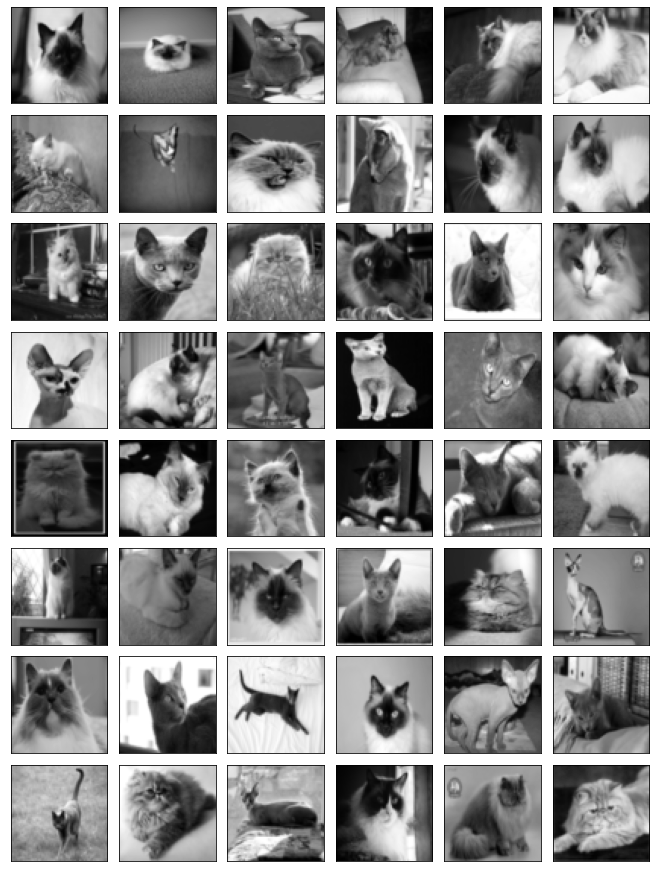


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



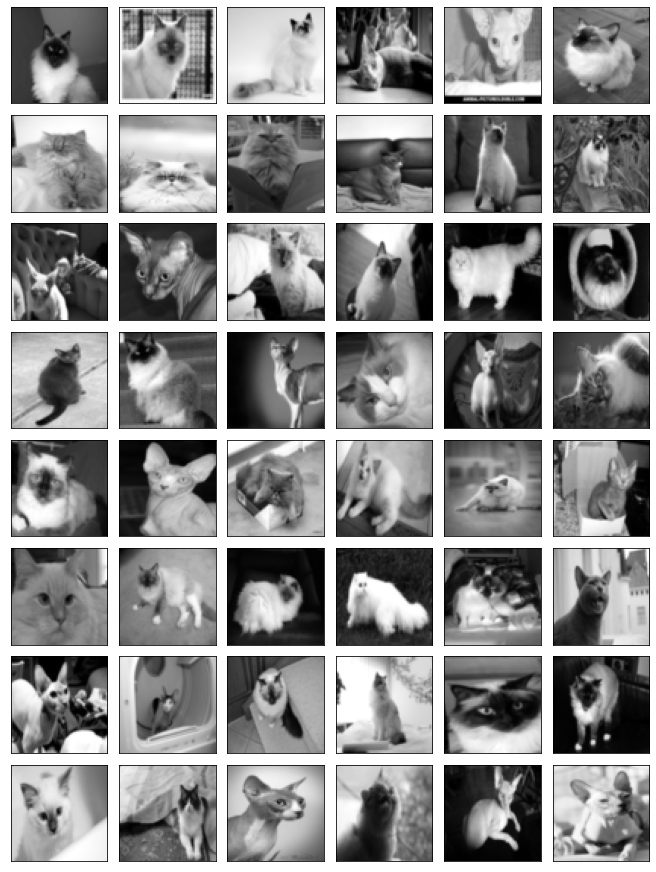


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



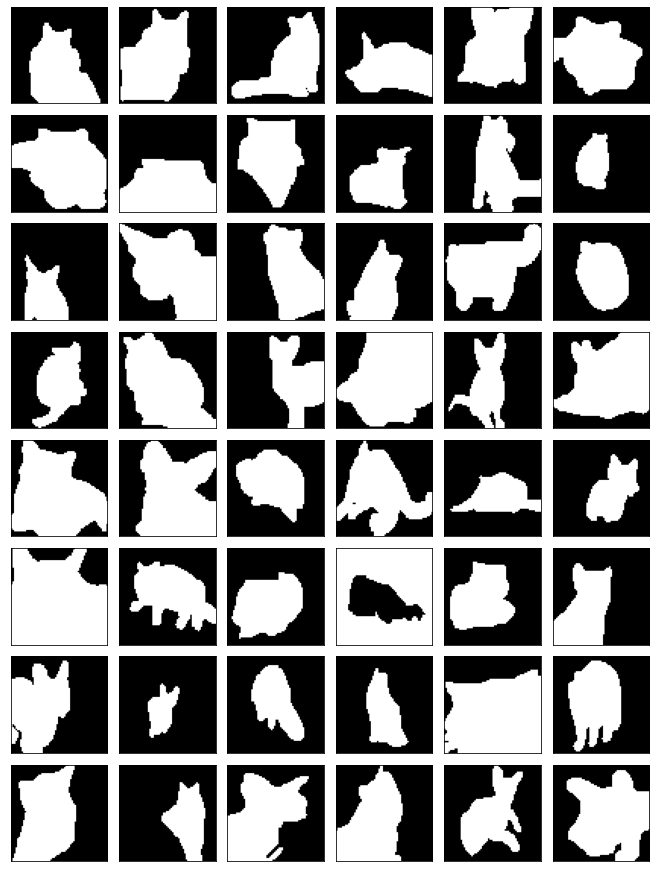


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



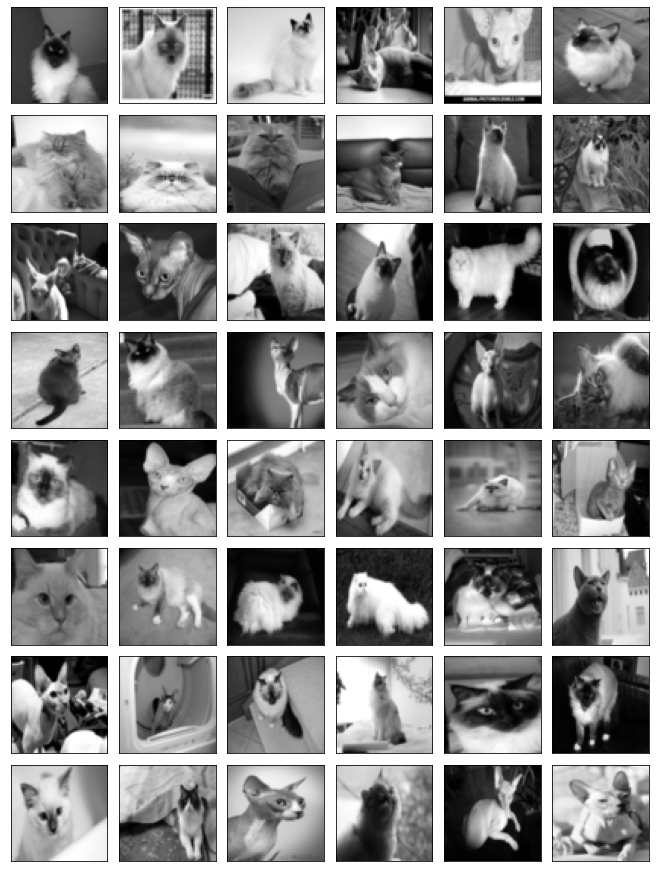


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



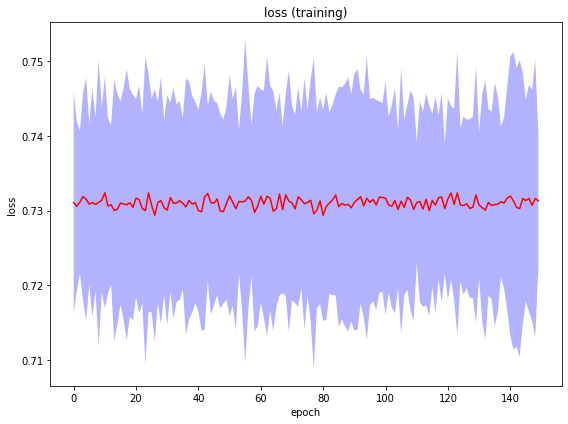


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



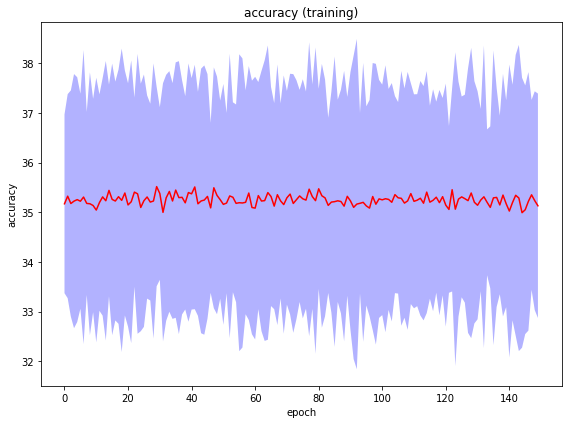


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



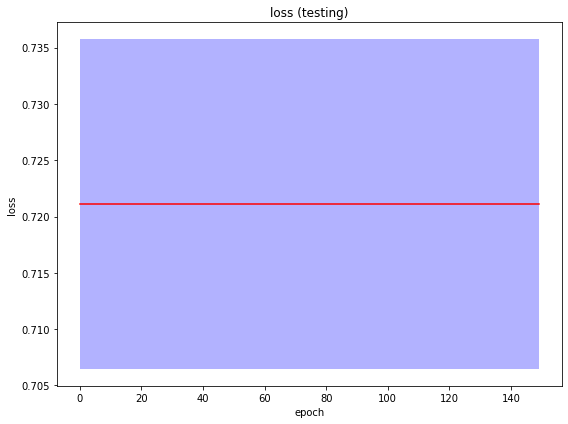


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



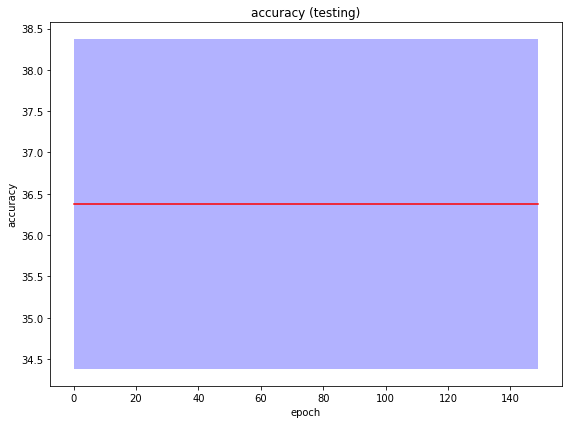


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.7319508261
index =  1, value = 0.7313329313
index =  2, value = 0.7304545144
index =  3, value = 0.7302771906
index =  4, value = 0.7316432794
index =  5, value = 0.7313501106
index =  6, value = 0.7316475643
index =  7, value = 0.7307148510
index =  8, value = 0.7316348486
index =  9, value = 0.7313174672

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 35.0246279472
index =  1, value = 35.1957635544
index =  2, value = 35.3415702742
index =  3, value = 35.2866777398
index =  4, value = 34.9911987007
index =  5, value = 35.0510310826


In [48]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)